
# Organizing Meal Product per Shop 

This notebook extends the previous meal deal optimization by creating **multiple meal deals** per shop using:  
- Top N **best-selling** products
- Bottom M **least-selling** products

Each deal has a **suggested price** based on historical prices.

**Benefits:**  
- Promote several least-selling items alongside popular ones.  
- Provide variety for customers.  
- Increase overall order value.


## Step 1: Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

sns.set(style="whitegrid")


## Step 2: Create Sample Dataset

In [2]:

# Simulated dataset with price information
np.random.seed(42)

shops = ['Pizza Hub', 'Sushi World', 'Burger Town', 'Healthy Bites']
foods = {
    'Pizza Hub': ['Margherita', 'Pepperoni', 'BBQ Chicken', 'Veggie Pizza'],
    'Sushi World': ['Salmon Roll', 'Tuna Sashimi', 'California Roll', 'Miso Soup'],
    'Burger Town': ['Cheeseburger', 'Chicken Burger', 'Fries', 'Onion Rings'],
    'Healthy Bites': ['Vegan Salad', 'Avocado Toast', 'Smoothie Bowl', 'Quinoa Wrap']
}

# Random price for each item
food_prices = {shop: {food: round(np.random.uniform(5,15),2) for food in items} for shop, items in foods.items()}

rows = []
order_id = 1
for _ in range(1000):
    shop = np.random.choice(shops)
    food = np.random.choice(foods[shop])
    customer = np.random.randint(1, 200)
    qty = np.random.randint(1, 4)
    price = food_prices[shop][food] * qty
    rows.append([order_id, shop, customer, food, qty, price])
    order_id += 1

data = pd.DataFrame(rows, columns=['order_id','shop_id','customer_id','food_item','quantity','price'])
data.head()


,order_id,shop_id,customer_id,food_item,quantity,price
0,1,Healthy Bites,22,Avocado Toast,1,7.12
1,2,Healthy Bites,49,Vegan Salad,3,39.96
2,3,Burger Town,170,Fries,3,15.63
3,4,Sushi World,175,Tuna Sashimi,2,13.12
4,5,Burger Town,55,Onion Rings,1,14.70


## Step 3: Exploratory Data Analysis

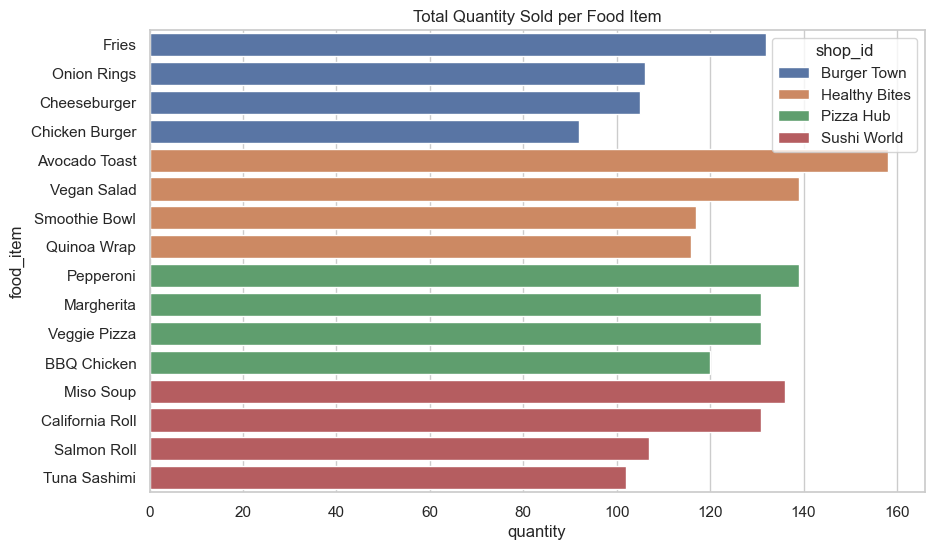

In [3]:

# Total quantity per item
item_sales = data.groupby(['shop_id','food_item'])['quantity'].sum().reset_index()
item_sales.sort_values(['shop_id','quantity'], ascending=[True, False], inplace=True)

# Plot total quantity per shop
plt.figure(figsize=(10,6))
sns.barplot(data=item_sales, x='quantity', y='food_item', hue='shop_id', dodge=False)
plt.title("Total Quantity Sold per Food Item")
plt.show()


## Step 4: Top N & Bottom M Items per Shop

In [4]:

N = 2  # Top 2 best-selling items
M = 2  # Bottom 2 least-selling items

# Create best-selling and least-selling item lists per shop
best_items = item_sales.groupby('shop_id').apply(lambda x: x.nlargest(N, 'quantity')).reset_index(drop=True)
least_items = item_sales.groupby('shop_id').apply(lambda x: x.nsmallest(M, 'quantity')).reset_index(drop=True)

best_items.rename(columns={'food_item':'best_item','quantity':'best_qty'}, inplace=True)
least_items.rename(columns={'food_item':'least_item','quantity':'least_qty'}, inplace=True)

best_items, least_items


C:\Users\SPINO SHOP\AppData\Local\Temp\ipykernel_22656\2911934708.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_items = item_sales.groupby('shop_id').apply(lambda x: x.nlargest(N, 'quantity')).reset_index(drop=True)
C:\Users\SPINO SHOP\AppData\Local\Temp\ipykernel_22656\2911934708.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  least_items = item_sales.groupby('shop_id').apply(lambda x: x.nsm

(         shop_id        best_item  best_qty
 0    Burger Town            Fries       132
 1    Burger Town      Onion Rings       106
 2  Healthy Bites    Avocado Toast       158
 3  Healthy Bites      Vegan Salad       139
 4      Pizza Hub        Pepperoni       139
 5      Pizza Hub       Margherita       131
 6    Sushi World        Miso Soup       136
 7    Sushi World  California Roll       131,
          shop_id      least_item  least_qty
 0    Burger Town  Chicken Burger         92
 1    Burger Town    Cheeseburger        105
 2  Healthy Bites     Quinoa Wrap        116
 3  Healthy Bites   Smoothie Bowl        117
 4      Pizza Hub     BBQ Chicken        120
 5      Pizza Hub      Margherita        131
 6    Sushi World    Tuna Sashimi        102
 7    Sushi World     Salmon Roll        107)

## Step 5: Meal Deal Creation

In [5]:

meal_deals_list = []

for shop in shops:
    best_list = best_items[best_items['shop_id']==shop]
    least_list = least_items[least_items['shop_id']==shop]
    
    # Create all combinations of best + least items
    for b, l in itertools.product(best_list.itertuples(index=False), least_list.itertuples(index=False)):
        meal_deals_list.append({
            'shop_id': shop,
            'best_item': b.best_item,
            'best_qty': b.best_qty,
            'least_item': l.least_item,
            'least_qty': l.least_qty
        })

meal_deals = pd.DataFrame(meal_deals_list)
meal_deals.head()


,shop_id,best_item,best_qty,least_item,least_qty
0,Pizza Hub,Pepperoni,139,BBQ Chicken,120
1,Pizza Hub,Pepperoni,139,Margherita,131
2,Pizza Hub,Margherita,131,BBQ Chicken,120
3,Pizza Hub,Margherita,131,Margherita,131
4,Sushi World,Miso Soup,136,Tuna Sashimi,102


## Step 6: Suggested Meal Deal Price

In [6]:

# Average price per item
avg_prices = data.groupby(['shop_id','food_item'])['price'].sum()/data.groupby(['shop_id','food_item'])['quantity'].sum()

def get_price(row):
    best_price = avg_prices.loc[row['shop_id'], row['best_item']]
    least_price = avg_prices.loc[row['shop_id'], row['least_item']]
    # Suggested price: 90% of sum of individual prices
    return round(0.9*(best_price + least_price),2)

meal_deals['suggested_price'] = meal_deals.apply(get_price, axis=1)
meal_deals


,shop_id,best_item,best_qty,least_item,least_qty,suggested_price
0,Pizza Hub,Pepperoni,139,BBQ Chicken,120,24.15
1,Pizza Hub,Pepperoni,139,Margherita,131,20.93
2,Pizza Hub,Margherita,131,BBQ Chicken,120,18.96
3,Pizza Hub,Margherita,131,Margherita,131,15.75
4,Sushi World,Miso Soup,136,Tuna Sashimi,102,18.20
5,Sushi World,Miso Soup,136,Salmon Roll,107,18.20
6,Sushi World,California Roll,131,Tuna Sashimi,102,10.93
7,Sushi World,California Roll,131,Salmon Roll,107,10.93
8,Burger Town,Fries,132,Chicken Burger,92,15.56
9,Burger Town,Fries,132,Cheeseburger,105,14.60


## Step 7: Visualize Multiple Meal Deals

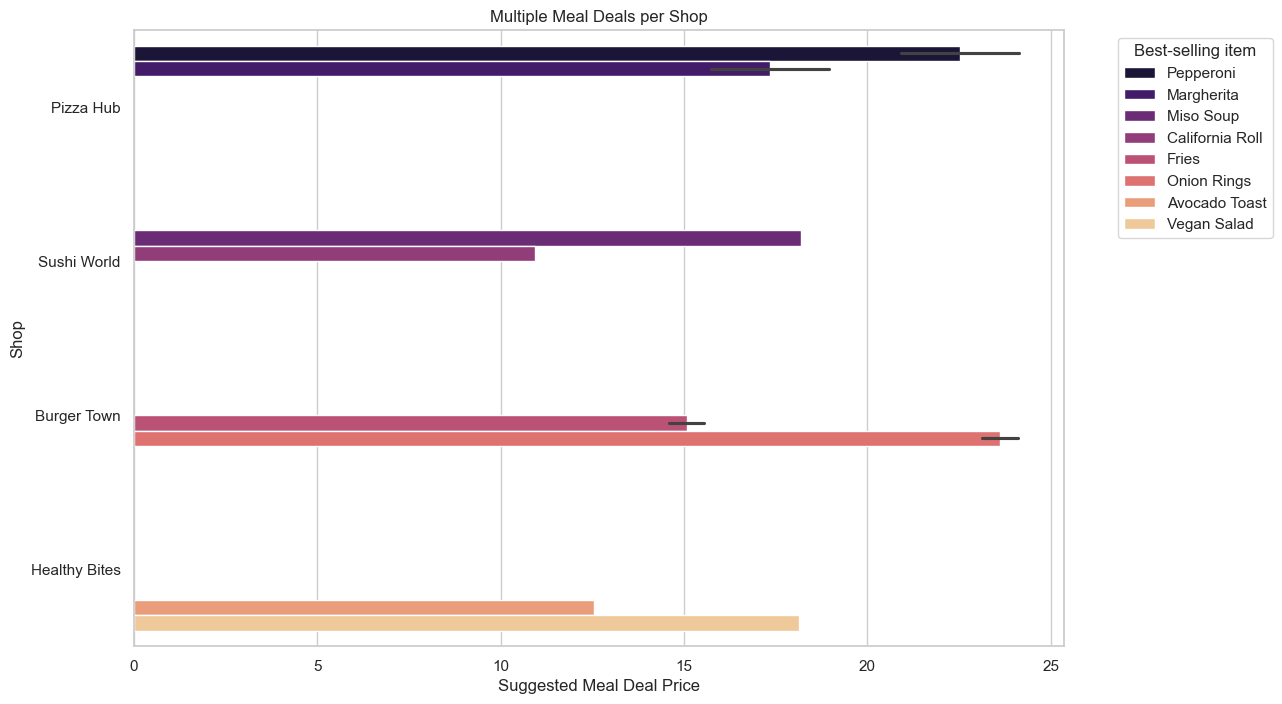

In [7]:

plt.figure(figsize=(12,8))
sns.barplot(data=meal_deals, x='suggested_price', y='shop_id', hue='best_item', dodge=True, palette='magma')
plt.xlabel("Suggested Meal Deal Price")
plt.ylabel("Shop")
plt.title("Multiple Meal Deals per Shop")
plt.legend(title='Best-selling item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



## Step 8: Conclusion & Business Use Case

- We created **multiple meal deals** per shop using several top-selling and least-selling items.  
- Suggested **prices** for each meal deal with a discount strategy.  
- Variety in deals can help promote less popular items while maintaining appeal of best-sellers.  

**Next Steps:**  
- Use real Provider order and price data.  
- Experiment with different discount rates for meal deals.  
- Automate the creation of new meal deals weekly or monthly.  
